#### Create Models (50 POINTS)
Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

#### Model Advantages (10 POINTS)
Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

#### Interpret Feature Importance (30 POINTS)
Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

#### Interpret Support Vectors (10 POINTS)
Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

# Mini-Lab

#### Alan Abadzic, John Girard, Eric Laigaie, Garrett Shankel

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("NY_Listings_Validated.csv")

##### Data Load-In and Preprocessing

In [2]:
# First, we need to create our classification column. Any rentals with a Review Scores Rating above 90 receive "A" (or 1),
# else recieve "Not A" (or 0).

def categorise(row):  
    if row['Review Scores Rating'] > 89:
        return 1
    else:
        return 0
    return 'IDK'

df['Grade'] = df.apply(lambda row: categorise(row), axis=1)

In [11]:
# Filter to only useful columns
data = df[['Host Response Rate', 'Host Is Superhost', 'Host total listings count', 'City', 'Room type',
          'Accommodates', 'Bathrooms', 'Bedrooms', 'Price', 'Minimum nights', 'Maximum nights', 'Availability 365',
          'Number of reviews', 'Reviews per month', 'Grade']]



# One-hot Encode
city_one_hot = pd.get_dummies(data['City'])
room_one_hot = pd.get_dummies(data['Room type'])

data = data.drop('City',axis = 1)
data = data.drop('Room type',axis = 1)

data = data.join(city_one_hot)
data = data.join(room_one_hot)


# Map boolean to integer
data["Host Is Superhost"] = data["Host Is Superhost"].astype(int)



# Scale Data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

grade = data['Grade']
to_scale = data.drop("Grade", axis = 1)
cols = to_scale.columns

scaled = scaler.fit_transform(to_scale)

data = pd.DataFrame(scaled, columns = cols)
data['Grade'] = grade
print(data)

       Host Response Rate  Host Is Superhost  Host total listings count  \
0                     1.0                0.0                   0.004086   
1                     1.0                0.0                   0.001021   
2                     1.0                0.0                   0.016343   
3                     0.7                0.0                   0.001021   
4                     1.0                0.0                   0.001021   
...                   ...                ...                        ...   
44020                 1.0                0.0                   0.001021   
44021                 1.0                0.0                   0.001021   
44022                 1.0                0.0                   0.001021   
44023                 1.0                0.0                   0.001021   
44024                 1.0                0.0                   0.001021   

       Accommodates  Bathrooms  Bedrooms     Price  Minimum nights  \
0          0.000000   0.06451

In [4]:
# Split into 80/20 train/test split.
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

print("Train: " + str(len(train)) + ", Test: " + str(len(test)))

train_y = train['Grade']
train_x = train.drop('Grade', axis=1)
test_y = train['Grade']
test_x = train.drop('Grade', axis=1)

Train: 35220, Test: 8805


## Create Models

#### Logistic Regression Testing

In [5]:
# Logistic Regression Model
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression
import time

penalties = ['none', 'l1', 'l2', 'elasticnet']
print("Testing different penalties:")
for penalty in penalties:
    start = time.time()
    if penalty == 'elasticnet':
        clf = LogisticRegression(max_iter=1000, penalty=penalty, solver='saga', l1_ratio =0.5).fit(train_x, train_y)
    else:
        clf = LogisticRegression(max_iter=1000, penalty=penalty, solver='saga').fit(train_x, train_y)
    end = time.time()
    predictions = clf.predict(test_x)
    acc = round((mt.accuracy_score(predictions, test_y)) * 100,2)
    print(penalty + ": " + str(acc) + '%, Time: ' + str(end - start) + ' seconds')

print('\n')
Cs = [0.05, .5, 1, 100]
print("Testing different C values with Elastic Net penalty:")
for c in Cs:
    start = time.time()
    clf = LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5, C=c).fit(train_x, train_y)
    end = time.time()
    predictions = clf.predict(test_x)
    acc = round((mt.accuracy_score(predictions, test_y)) * 100,2)
    print(str(c) + ": " + str(acc) + '%, Time: ' + str(end - start) + ' seconds')

Testing different penalties:
none: 71.75%, Time: 10.37828540802002 seconds
l1: 71.73%, Time: 0.24453306198120117 seconds
l2: 71.88%, Time: 0.23715758323669434 seconds
elasticnet: 71.81%, Time: 0.29659295082092285 seconds


Testing different C values with Elastic Net penalty:
0.05: 70.26%, Time: 0.2720518112182617 seconds
0.5: 71.89%, Time: 0.30833959579467773 seconds
1: 71.83%, Time: 0.37259697914123535 seconds
100: 71.75%, Time: 5.571760654449463 seconds


#### SVM Testing

In [6]:
from sklearn.svm import SVC
import time

kernels = ['rbf', 'linear', 'poly', 'sigmoid']

print("Testing different kernels:")
for kernel in kernels:
    start = time.time()
    svm_clf = SVC(C=0.5, kernel=kernel, degree=3, gamma='auto').fit(train_x, train_y)
    end = time.time()
    predictions = svm_clf.predict(test_x)
    acc = str(round(mt.accuracy_score(predictions, test_y)*100, 2))
    print(kernel + ": " + acc + '%, Time: ' + str(end - start) + ' seconds')

Testing different kernels:
rbf: 63.08%, Time: 50.80089235305786 seconds
linear: 67.98%, Time: 33.211557388305664 seconds
poly: 62.66%, Time: 38.80069136619568 seconds
sigmoid: 62.95%, Time: 49.00444221496582 seconds


## Model Advantages

Between the logistic regression (LR) and support vector machine (SVM) models, the superior technique is fairly easy to spot in this case. I'll break this down:

##### Time:
As you can see from the print outs above, most of the LR models are created within 1 second. That is a drastic improvement from the SVM, which takes at least 45 seconds. This allows us to test the LR parameters much more than the SVM ones.

##### Accuracy:
Given our classification problem, it appears that LR is consistently the more accurate model. The LR models all sit around 71% accuracy while the SVM models range from 63% to 69%. More exploration into the linear SVM model could yield similar results to the LR models, given the small difference in accuracy percentages.

##### Future Suggestions:
When given plenty of time, grid search cv could and should be used here to hypertune parameters. However, when we attempted it with the SVM model, we decided to abandon it after it ran for approximately 30 minutes with no final results.

## Interpret Feature Importance

In [7]:
clf = LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5, C=100).fit(train_x, train_y)
predictions = clf.predict(test_x)
acc = round((mt.accuracy_score(predictions, test_y)) * 100,2)

zip_vars = zip(clf.coef_.T,data.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', round(coef[0],4))

Maximum nights has weight of -5.9648
Host total listings count has weight of -2.0312
Minimum nights has weight of -1.3126
Accommodates has weight of -1.2174
Bedrooms has weight of -0.4537
Shared room has weight of -0.317
Bronx has weight of -0.1347
Staten Island has weight of -0.129
Price has weight of -0.0871
Private room has weight of -0.0448
Bathrooms has weight of -0.0055
Queens has weight of 0.0
Availability 365 has weight of 0.0351
Manhattan has weight of 0.083
Host Response Rate has weight of 0.1671
Brooklyn has weight of 0.2832
Entire home/apt has weight of 0.4766
Number of reviews has weight of 0.571
Host Is Superhost has weight of 2.1877
Reviews per month has weight of 14.447


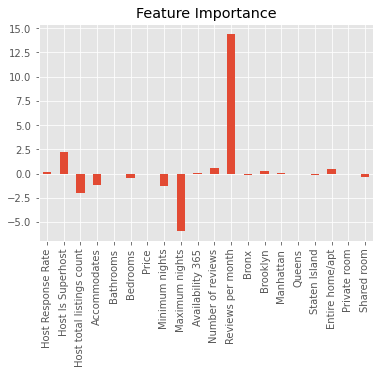

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(clf.coef_[0],index=data.columns[0:20])
weights.plot(kind='bar')
plt.title('Feature Importance')
plt.show()

#### Interpretation:
I understand that these values shown above may cause some worry about variable scaling. However, the entire dataset used in the models was scaled before model creation. The most significant variables will be discussed below.

##### Reviews per Month:
The highest feature with the highest magnitude of importance - this indicates that when a rental has more reviews per month, it is much more likely to get an overall rating or 90 or above (and A). This makes sense! More reviews means more bookings, and more bookings are much more likely if the past reviews are high instead of low.

##### Host is Superhost:
This has a fairly significant positive value. Again, this makes sense, as superhosts are likely to be more invested in their rentals, leading to higher review scores.

##### Maximum Nights:
Some postulating here - a higher maximum nights value should give renters more flexibility. Additionally, if clients are spending longer amounts of time in a rental, the property owner may feel more motivated to keep it maintained.

##### Host Total Listings Count:
This is the most negative variable. A possible explanation is that property owners that manage large numbers of rentals likely have less time to take care of each individual one.

##### City

Brooklyn: 0.2959
Manhattan: 0.129
Queens: 0.00
Bronx: -0.0573
Staten Island: -0.1285

These values check out from my very novice understanding of New York City. You could theorize that Brooklyn likely has larger rentals that skew a little cheaper than Manhattan. For Queens, Bronx, and Staten Island, these values almost correlate with distance to Manhattan.

##### Room Type

Entire Home / Apt: .5222
Private Room: 0.0
Shared Room: -0.2307

These variables come accross exactly how we would expect. It makes complete sense that renters with a shared room would rate the Airbnbs lower than if they had a private room or entire rental to themselves.

### Interpret Support Vectors

In [9]:
#svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto').fit(train_x, train_y)
#predictions = svm_clf.predict(test_x)

df_train = train_x
df_support = df_train.iloc[svm_clf.support_,:]

df_train['Grade'] = train_y
df_support['Grade'] = train_y[svm_clf.support_]

#df_support.info()

#df_tested_on = df_imputed.iloc[train_indices].copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
#df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

#df_support['Survived'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
#df_imputed['Survived'] = y # also add it back in for the original data
#df_support.info()

KeyError: '[17, 23, 37, 46, 53, 54, 63, 87, 88, 122, 149, 156, 157, 180, 182, 199, 218, 238, 264, 297, 304, 315, 319, 320, 330, 331, 337, 369, 373, 383, 385, 386, 389, 395, 402, 416, 417, 425, 442, 529, 590, 591, 604, 606, 619, 640, 647, 667, 693, 695, 727, 741, 743, 771, 774, 787, 811, 825, 831, 853, 880, 889, 908, 909, 934, 946, 958, 978, 996, 1025, 1057, 1077, 1091, 1113, 1121, 1240, 1244, 1252, 1269, 1270, 1278, 1283, 1288, 1318, 1326, 1354, 1368, 1394, 1396, 1418, 1429, 1430, 1433, 1441, 1446, 1452, 1460, 1474, 1475, 1491, 1515, 1518, 1526, 1530, 1543, 1585, 1588, 1598, 1604, 1613, 1619, 1622, 1623, 1627, 1676, 1701, 1710, 1729, 1732, 1762, 1772, 1773, 1777, 1805, 1831, 1832, 1839, 1905, 1906, 1912, 1922, 1927, 1951, 1958, 1975, 1978, 1993, 2001, 2003, 2011, 2014, 2019, 2027, 2038, 2043, 2046, 2055, 2068, 2078, 2087, 2108, 2186, 2203, 2204, 2208, 2210, 2218, 2223, 2233, 2251, 2272, 2285, 2292, 2310, 2315, 2339, 2348, 2349, 2356, 2373, 2375, 2417, 2430, 2440, 2441, 2448, 2460, 2469, 2486, 2489, 2510, 2511, 2517, 2521, 2578, 2589, 2602, 2606, 2613, 2632, 2637, 2638, 2656, 2661, 2689, 2693, 2695, 2706, 2724, 2728, 2761, 2763, 2765, 2774, 2796, 2798, 2806, 2807, 2820, 2861, 2865, 2867, 2872, 2886, 2891, 2909, 2961, 2962, 3006, 3025, 3047, 3056, 3059, 3060, 3065, 3068, 3087, 3103, 3131, 3145, 3148, 3155, 3173, 3185, 3190, 3196, 3203, 3208, 3238, 3247, 3249, 3266, 3267, 3282, 3307, 3320, 3322, 3327, 3356, 3375, 3378, 3379, 3403, 3409, 3414, 3441, 3502, 3507, 3539, 3553, 3581, 3592, 3593, 3601, 3602, 3626, 3635, 3659, 3662, 3684, 3700, 3709, 3714, 3718, 3729, 3757, 3766, 3783, 3803, 3819, 3840, 3845, 3862, 3881, 3895, 3896, 3912, 3914, 3948, 3973, 3987, 3999, 4040, 4051, 4064, 4082, 4089, 4091, 4103, 4113, 4115, 4137, 4186, 4190, 4193, 4208, 4247, 4264, 4268, 4273, 4277, 4281, 4308, 4314, 4316, 4317, 4329, 4337, 4341, 4344, 4361, 4369, 4379, 4397, 4416, 4421, 4425, 4429, 4450, 4451, 4458, 4473, 4480, 4483, 4485, 4488, 4503, 4547, 4548, 4550, 4567, 4568, 4592, 4606, 4608, 4617, 4619, 4632, 4665, 4682, 4684, 4685, 4721, 4728, 4729, 4737, 4741, 4777, 4786, 4796, 4821, 4853, 4863, 4868, 4875, 4877, 4913, 4919, 4961, 4979, 4981, 4992, 4999, 5066, 5075, 5124, 5168, 5197, 5211, 5232, 5234, 5235, 5255, 5279, 5288, 5291, 5310, 5349, 5381, 5385, 5394, 5406, 5407, 5412, 5420, 5421, 5438, 5448, 5451, 5452, 5459, 5471, 5473, 5484, 5488, 5497, 5514, 5517, 5519, 5521, 5528, 5533, 5556, 5557, 5559, 5587, 5612, 5640, 5665, 5680, 5684, 5691, 5696, 5711, 5720, 5722, 5758, 5763, 5764, 5776, 5789, 5801, 5809, 5819, 5826, 5839, 5850, 5854, 5859, 5874, 5875, 5891, 5892, 5893, 5900, 5927, 5960, 5976, 5990, 6024, 6032, 6062, 6066, 6080, 6085, 6115, 6145, 6149, 6151, 6176, 6177, 6191, 6195, 6221, 6226, 6227, 6229, 6236, 6246, 6255, 6283, 6285, 6287, 6306, 6324, 6339, 6364, 6374, 6377, 6378, 6388, 6420, 6433, 6435, 6439, 6440, 6450, 6462, 6491, 6505, 6519, 6541, 6569, 6575, 6599, 6635, 6652, 6658, 6663, 6668, 6681, 6698, 6715, 6727, 6747, 6811, 6814, 6826, 6828, 6869, 6924, 6925, 6931, 6936, 6946, 6955, 6968, 6977, 6988, 6993, 6994, 7002, 7018, 7039, 7060, 7068, 7087, 7092, 7095, 7099, 7118, 7119, 7121, 7127, 7136, 7160, 7169, 7196, 7198, 7245, 7274, 7276, 7283, 7300, 7303, 7310, 7344, 7359, 7375, 7392, 7399, 7403, 7422, 7431, 7437, 7442, 7447, 7452, 7459, 7467, 7480, 7499, 7504, 7507, 7543, 7552, 7559, 7579, 7586, 7587, 7590, 7593, 7618, 7624, 7641, 7650, 7662, 7674, 7677, 7684, 7687, 7698, 7714, 7722, 7743, 7744, 7752, 7760, 7775, 7786, 7790, 7791, 7792, 7798, 7816, 7837, 7850, 7857, 7865, 7903, 7918, 7922, 7928, 7940, 7947, 7953, 7980, 7983, 7984, 8000, 8006, 8032, 8039, 8101, 8139, 8150, 8161, 8179, 8210, 8217, 8229, 8275, 8295, 8302, 8324, 8330, 8335, 8347, 8352, 8364, 8371, 8376, 8385, 8391, 8419, 8427, 8450, 8457, 8465, 8470, 8477, 8498, 8539, 8555, 8589, 8599, 8608, 8613, 8635, 8652, 8655, 8663, 8666, 8674, 8683, 8686, 8700, 8704, 8707, 8717, 8723, 8753, 8781, 8785, 8789, 8799, 8805, 8838, 8856, 8877, 8886, 8900, 8903, 8915, 8917, 8932, 8935, 8937, 8956, 8957, 8971, 8972, 8982, 8998, 9031, 9032, 9039, 9040, 9086, 9092, 9097, 9098, 9126, 9135, 9138, 9146, 9149, 9152, 9178, 9183, 9191, 9214, 9233, 9243, 9262, 9268, 9276, 9280, 9282, 9305, 9309, 9319, 9328, 9355, 9356, 9400, 9403, 9407, 9432, 9452, 9455, 9472, 9478, 9504, 9534, 9551, 9576, 9635, 9646, 9649, 9654, 9662, 9664, 9676, 9682, 9694, 9723, 9731, 9733, 9758, 9762, 9778, 9789, 9791, 9814, 9816, 9823, 9830, 9864, 9869, 9875, 9890, 9919, 9928, 9930, 9933, 9972, 9982, 9983, 9995, 10006, 10014, 10022, 10037, 10066, 10077, 10097, 10151, 10173, 10176, 10201, 10204, 10213, 10215, 10222, 10250, 10289, 10319, 10330, 10351, 10357, 10360, 10372, 10374, 10393, 10428, 10434, 10442, 10443, 10445, 10446, 10457, 10470, 10488, 10520, 10530, 10564, 10590, 10601, 10621, 10626, 10631, 10654, 10689, 10699, 10705, 10709, 10719, 10726, 10751, 10757, 10759, 10775, 10777, 10790, 10800, 10802, 10818, 10822, 10824, 10847, 10881, 10887, 10892, 10902, 10907, 10912, 10917, 10918, 10942, 10955, 10957, 10973, 10974, 10998, 11010, 11013, 11035, 11039, 11060, 11067, 11077, 11081, 11085, 11090, 11104, 11122, 11145, 11159, 11185, 11202, 11208, 11214, 11221, 11226, 11230, 11239, 11255, 11304, 11309, 11321, 11336, 11365, 11371, 11399, 11401, 11421, 11441, 11453, 11491, 11494, 11506, 11512, 11536, 11542, 11603, 11609, 11610, 11645, 11699, 11700, 11709, 11719, 11737, 11764, 11765, 11775, 11788, 11814, 11831, 11837, 11838, 11853, 11861, 11875, 11893, 11902, 11918, 11944, 11952, 11962, 11981, 11983, 11987, 11989, 11996, 12001, 12019, 12021, 12038, 12056, 12062, 12063, 12071, 12072, 12078, 12094, 12115, 12127, 12130, 12149, 12153, 12159, 12170, 12183, 12239, 12253, 12273, 12282, 12286, 12288, 12316, 12326, 12332, 12339, 12340, 12357, 12365, 12369, 12410, 12443, 12454, 12469, 12481, 12483, 12505, 12506, 12512, 12534, 12537, 12546, 12550, 12551, 12565, 12591, 12603, 12622, 12636, 12645, 12653, 12661, 12668, 12677, 12678, 12682, 12688, 12702, 12703, 12707, 12733, 12763, 12775, 12788, 12789, 12804, 12811, 12816, 12833, 12842, 12845, 12851, 12852, 12863, 12869, 12870, 12886, 12894, 12900, 12902, 12907, 12918, 12933, 12951, 12954, 12969, 12981, 12990, 12999, 13011, 13021, 13034, 13045, 13056, 13060, 13066, 13082, 13083, 13094, 13102, 13103, 13104, 13126, 13127, 13137, 13182, 13195, 13206, 13207, 13257, 13262, 13277, 13289, 13354, 13379, 13400, 13403, 13414, 13439, 13448, 13462, 13464, 13465, 13467, 13477, 13478, 13503, 13511, 13512, 13518, 13535, 13540, 13556, 13564, 13581, 13588, 13596, 13623, 13641, 13678, 13680, 13684, 13685, 13691, 13694, 13707, 13748, 13749, 13759, 13761, 13794, 13799, 13811, 13815, 13819, 13820, 13821, 13848, 13857, 13861, 13871, 13881, 13883, 13893, 13905, 13914, 13943, 13955, 13992, 14000, 14008, 14017, 14028, 14030, 14070, 14075, 14076, 14100, 14106, 14123, 14127, 14161, 14170, 14217, 14241, 14242, 14250, 14258, 14277, 14288, 14300, 14331, 14353, 14362, 14376, 14384, 14388, 14393, 14400, 14404, 14435, 14450, 14484, 14510, 14515, 14518, 14535, 14543, 14567, 14569, 14580, 14604, 14610, 14623, 14643, 14658, 14662, 14669, 14680, 14685, 14692, 14705, 14733, 14734, 14744, 14750, 14779, 14780, 14788, 14789, 14813, 14818, 14822, 14826, 14867, 14879, 14903, 14913, 14923, 14934, 14940, 14944, 14945, 14955, 14958, 14982, 15004, 15033, 15034, 15039, 15046, 15047, 15056, 15061, 15063, 15086, 15091, 15106, 15114, 15118, 15149, 15172, 15178, 15191, 15194, 15215, 15231, 15243, 15245, 15253, 15263, 15278, 15310, 15317, 15325, 15327, 15345, 15357, 15374, 15375, 15381, 15404, 15406, 15411, 15415, 15441, 15464, 15467, 15487, 15502, 15506, 15507, 15517, 15522, 15527, 15544, 15546, 15555, 15575, 15579, 15609, 15616, 15650, 15676, 15709, 15726, 15744, 15746, 15751, 15766, 15768, 15794, 15802, 15820, 15829, 15845, 15872, 15886, 15888, 15906, 15911, 15953, 15982, 16065, 16070, 16082, 16090, 16095, 16121, 16142, 16163, 16211, 16213, 16215, 16217, 16227, 16256, 16266, 16279, 16306, 16323, 16326, 16354, 16367, 16436, 16471, 16499, 16506, 16509, 16515, 16516, 16519, 16535, 16545, 16557, 16562, 16565, 16568, 16570, 16598, 16617, 16627, 16636, 16667, 16677, 16678, 16690, 16693, 16697, 16711, 16713, 16732, 16768, 16771, 16773, 16793, 16815, 16824, 16830, 16833, 16834, 16845, 16857, 16868, 16875, 16883, 16890, 16902, 16924, 16928, 16933, 16944, 16945, 16962, 16981, 16989, 17012, 17034, 17040, 17070, 17073, 17076, 17082, 17092, 17111, 17113, 17170, 17173, 17177, 17200, 17206, 17218, 17259, 17262, 17263, 17270, 17297, 17304, 17308, 17311, 17314, 17317, 17340, 17353, 17356, 17373, 17376, 17402, 17411, 17450, 17474, 17500, 17505, 17522, 17532, 17534, 17542, 17563, 17570, 17597, 17598, 17617, 17637, 17640, 17645, 17647, 17669, 17676, 17684, 17710, 17729, 17746, 17749, 17760, 17761, 17767, 17782, 17789, 17790, 17796, 17799, 17811, 17816, 17842, 17849, 17854, 17856, 17862, 17905, 17929, 17949, 17956, 18033, 18094, 18149, 18161, 18162, 18174, 18233, 18253, 18282, 18314, 18347, 18366, 18376, 18404, 18409, 18413, 18432, 18435, 18441, 18444, 18450, 18469, 18516, 18519, 18528, 18532, 18542, 18553, 18570, 18591, 18598, 18679, 18701, 18710, 18732, 18738, 18754, 18781, 18782, 18790, 18823, 18830, 18844, 18849, 18861, 18864, 18908, 18912, 18918, 18920, 18933, 18944, 18966, 18970, 19022, 19043, 19050, 19068, 19091, 19095, 19096, 19100, 19102, 19107, 19115, 19124, 19133, 19136, 19144, 19153, 19154, 19155, 19159, 19161, 19175, 19191, 19223, 19230, 19232, 19248, 19268, 19299, 19300, 19316, 19322, 19330, 19335, 19336, 19337, 19348, 19363, 19385, 19404, 19405, 19422, 19425, 19431, 19442, 19446, 19459, 19465, 19467, 19475, 19476, 19494, 19502, 19520, 19529, 19535, 19572, 19583, 19588, 19625, 19628, 19656, 19664, 19666, 19688, 19690, 19696, 19700, 19701, 19703, 19707, 19714, 19715, 19739, 19742, 19743, 19744, 19750, 19777, 19784, 19785, 19791, 19802, 19810, 19812, 19817, 19825, 19840, 19842, 19857, 19864, 19872, 19913, 19922, 19927, 19933, 19934, 19947, 19974, 19990, 19993, 19994, 20015, 20022, 20027, 20053, 20059, 20060, 20078, 20098, 20132, 20144, 20146, 20167, 20181, 20190, 20198, 20215, 20223, 20234, 20281, 20283, 20286, 20332, 20383, 20388, 20390, 20397, 20406, 20412, 20416, 20433, 20443, 20473, 20487, 20504, 20507, 20512, 20528, 20531, 20550, 20553, 20559, 20581, 20584, 20598, 20603, 20605, 20618, 20630, 20631, 20633, 20655, 20658, 20669, 20674, 20682, 20692, 20693, 20707, 20717, 20720, 20738, 20739, 20740, 20748, 20768, 20783, 20794, 20862, 20865, 20866, 20881, 20886, 20896, 20899, 20909, 20914, 20915, 20923, 20927, 20932, 20939, 20976, 20996, 21001, 21002, 21008, 21025, 21053, 21055, 21064, 21069, 21078, 21082, 21117, 21125, 21140, 21172, 21175, 21177, 21183, 21189, 21215, 21221, 21233, 21239, 21276, 21282, 21288, 21289, 21299, 21312, 21319, 21341, 21347, 21356, 21388, 21426, 21438, 21447, 21457, 21472, 21475, 21481, 21484, 21510, 21518, 21539, 21546, 21548, 21549, 21588, 21597, 21616, 21623, 21632, 21636, 21647, 21668, 21675, 21684, 21706, 21707, 21741, 21749, 21775, 21793, 21802, 21811, 21821, 21825, 21830, 21867, 21878, 21893, 21922, 21964, 21968, 21976, 21982, 21996, 22015, 22024, 22033, 22040, 22077, 22091, 22092, 22120, 22137, 22139, 22151, 22154, 22165, 22206, 22210, 22221, 22225, 22228, 22239, 22249, 22256, 22258, 22295, 22306, 22311, 22320, 22325, 22329, 22342, 22406, 22409, 22414, 22440, 22452, 22477, 22486, 22491, 22492, 22512, 22513, 22529, 22565, 22577, 22607, 22628, 22632, 22640, 22644, 22662, 22700, 22702, 22716, 22725, 22731, 22747, 22758, 22766, 22768, 22770, 22777, 22791, 22796, 22806, 22847, 22885, 22939, 22949, 22969, 22972, 23003, 23019, 23023, 23024, 23047, 23048, 23075, 23082, 23095, 23108, 23117, 23136, 23197, 23201, 23242, 23257, 23290, 23297, 23303, 23310, 23331, 23339, 23374, 23383, 23400, 23406, 23451, 23465, 23487, 23528, 23562, 23575, 23581, 23584, 23585, 23595, 23627, 23628, 23660, 23666, 23677, 23694, 23695, 23702, 23708, 23740, 23742, 23766, 23768, 23770, 23784, 23789, 23810, 23835, 23856, 23878, 23894, 23918, 23919, 23930, 23957, 23978, 23995, 24013, 24046, 24047, 24057, 24059, 24076, 24088, 24111, 24125, 24129, 24133, 24155, 24208, 24210, 24214, 24222, 24223, 24225, 24241, 24247, 24251, 24280, 24295, 24299, 24305, 24325, 24330, 24333, 24338, 24409, 24410, 24430, 24445, 24470, 24507, 24511, 24535, 24552, 24570, 24590, 24622, 24644, 24645, 24654, 24658, 24663, 24678, 24710, 24758, 24779, 24784, 24793, 24798, 24806, 24823, 24827, 24831, 24840, 24848, 24858, 24876, 24881, 24891, 24903, 24910, 24917, 24922, 24939, 24942, 25033, 25035, 25051, 25085, 25126, 25128, 25136, 25144, 25155, 25159, 25161, 25169, 25186, 25199, 25200, 25231, 25246, 25265, 25272, 25274, 25291, 25296, 25302, 25339, 25386, 25402, 25406, 25411, 25438, 25441, 25447, 25452, 25453, 25458, 25472, 25485, 25498, 25501, 25502, 25510, 25511, 25514, 25517, 25523, 25527, 25544, 25548, 25558, 25613, 25623, 25631, 25634, 25670, 25672, 25679, 25695, 25724, 25734, 25750, 25761, 25782, 25817, 25839, 25862, 25876, 25886, 25892, 25894, 25935, 25954, 25969, 25977, 25979, 25982, 26034, 26035, 26044, 26059, 26066, 26075, 26082, 26084, 26089, 26093, 26095, 26098, 26104, 26110, 26132, 26134, 26163, 26190, 26226, 26233, 26291, 26298, 26304, 26306, 26316, 26319, 26326, 26341, 26346, 26350, 26356, 26361, 26370, 26381, 26403, 26408, 26410, 26444, 26464, 26479, 26484, 26486, 26511, 26539, 26555, 26568, 26584, 26588, 26598, 26601, 26620, 26642, 26655, 26701, 26707, 26737, 26738, 26770, 26775, 26804, 26811, 26841, 26852, 26858, 26865, 26870, 26875, 26885, 26890, 26902, 26921, 26925, 26944, 26947, 26954, 26965, 26968, 26973, 26984, 27011, 27025, 27041, 27049, 27071, 27085, 27111, 27124, 27147, 27160, 27162, 27176, 27186, 27192, 27193, 27199, 27219, 27244, 27248, 27255, 27259, 27266, 27269, 27295, 27310, 27331, 27380, 27385, 27392, 27398, 27419, 27456, 27461, 27474, 27504, 27509, 27554, 27563, 27574, 27575, 27583, 27591, 27592, 27597, 27601, 27621, 27626, 27639, 27650, 27662, 27665, 27675, 27707, 27711, 27715, 27732, 27733, 27734, 27746, 27760, 27763, 27766, 27773, 27787, 27797, 27821, 27829, 27837, 27850, 27856, 27898, 27908, 27915, 27918, 27922, 27927, 27929, 27942, 27961, 27963, 27971, 27974, 27999, 28004, 28008, 28027, 28034, 28035, 28040, 28048, 28081, 28086, 28087, 28092, 28113, 28119, 28135, 28181, 28203, 28219, 28234, 28239, 28243, 28276, 28280, 28327, 28341, 28359, 28373, 28387, 28420, 28421, 28427, 28438, 28440, 28451, 28465, 28470, 28475, 28490, 28509, 28542, 28564, 28583, 28585, 28587, 28601, 28604, 28632, 28646, 28647, 28713, 28725, 28727, 28735, 28737, 28799, 28813, 28826, 28831, 28843, 28845, 28849, 28850, 28853, 28860, 28867, 28873, 28881, 28884, 28894, 28921, 28928, 28953, 28956, 28963, 28989, 28994, 29000, 29018, 29033, 29038, 29054, 29059, 29073, 29109, 29130, 29157, 29160, 29164, 29186, 29188, 29195, 29240, 29279, 29286, 29295, 29298, 29306, 29312, 29327, 29387, 29431, 29449, 29458, 29476, 29490, 29497, 29501, 29511, 29529, 29547, 29551, 29563, 29569, 29571, 29577, 29580, 29603, 29608, 29628, 29642, 29664, 29668, 29677, 29696, 29714, 29732, 29761, 29781, 29790, 29797, 29798, 29802, 29817, 29819, 29823, 29838, 29919, 29920, 29932, 29940, 29964, 29973, 29977, 29992, 30012, 30034, 30057, 30062, 30076, 30085, 30088, 30098, 30114, 30147, 30176, 30177, 30191, 30205, 30215, 30217, 30254, 30257, 30259, 30270, 30290, 30297, 30300, 30308, 30310, 30347, 30349, 30372, 30379, 30421, 30455, 30456, 30461, 30468, 30471, 30492, 30499, 30502, 30535, 30548, 30565, 30567, 30576, 30586, 30608, 30626, 30631, 30633, 30639, 30660, 30690, 30697, 30718, 30735, 30738, 30783, 30799, 30805, 30806, 30808, 30823, 30829, 30833, 30846, 30854, 30875, 30882, 30885, 30886, 30894, 30916, 30940, 30946, 30964, 30965, 30980, 30983, 30984, 30994, 31009, 31015, 31034, 31047, 31054, 31081, 31114, 31117, 31124, 31126, 31151, 31152, 31155, 31165, 31166, 31168, 31220, 31230, 31252, 31260, 31264, 31285, 31296, 31315, 31318, 31324, 31330, 31340, 31342, 31358, 31359, 31360, 31363, 31373, 31398, 31415, 31435, 31507, 31514, 31518, 31550, 31554, 31571, 31589, 31602, 31624, 31632, 31656, 31661, 31687, 31690, 31720, 31723, 31728, 31729, 31730, 31743, 31761, 31769, 31786, 31794, 31797, 31800, 31811, 31830, 31844, 31848, 31850, 31851, 31855, 31868, 31881, 31916, 31941, 31976, 31985, 31987, 31999, 32033, 32037, 32053, 32063, 32097, 32108, 32120, 32136, 32144, 32151, 32156, 32162, 32176, 32182, 32204, 32216, 32226, 32228, 32237, 32244, 32281, 32284, 32309, 32318, 32327, 32334, 32341, 32342, 32366, 32377, 32380, 32386, 32401, 32404, 32413, 32417, 32456, 32463, 32469, 32500, 32503, 32509, 32511, 32514, 32518, 32522, 32526, 32555, 32565, 32576, 32598, 32614, 32615, 32623, 32632, 32660, 32667, 32695, 32697, 32700, 32702, 32705, 32728, 32735, 32757, 32765, 32776, 32795, 32810, 32823, 32826, 32856, 32876, 32879, 32895, 32917, 32920, 32923, 32925, 32929, 32943, 32947, 32969, 32972, 32980, 33000, 33043, 33045, 33048, 33051, 33086, 33096, 33099, 33108, 33119, 33122, 33133, 33140, 33145, 33156, 33157, 33160, 33165, 33197, 33198, 33211, 33214, 33215, 33220, 33224, 33271, 33297, 33300, 33326, 33361, 33369, 33382, 33391, 33403, 33413, 33415, 33419, 33421, 33430, 33432, 33437, 33439, 33446, 33452, 33527, 33556, 33583, 33592, 33595, 33600, 33609, 33611, 33639, 33656, 33686, 33694, 33714, 33745, 33755, 33785, 33804, 33828, 33846, 33854, 33858, 33860, 33861, 33871, 33883, 33891, 33914, 33917, 33928, 33942, 33956, 33962, 33965, 33978, 33991, 33994, 34036, 34038, 34041, 34071, 34103, 34115, 34126, 34127, 34145, 34158, 34161, 34198, 34201, 34215, 34225, 34232, 34267, 34272, 34275, 34276, 34293, 34321, 34327, 34348, 34358, 34361, 34377, 34382, 34388, 34412, 34431, 34439, 34440, 34460, 34462, 34474, 34481, 34494, 34511, 34514, 34524, 34536, 34542, 34551, 34567, 34585, 34634, 34661, 34686, 34697, 34700, 34704, 34714, 34727, 34746, 34765, 34801, 34806, 34810, 34814, 34843, 34850, 34852, 34855, 34881, 34885, 34897, 34959, 34974, 34980, 34993, 35007, 35008, 35027, 35029, 35037, 35044, 35060, 35074, 35111, 35146, 35170, 35174, 35175, 35184, 35207, 35219, 44, 45, 62, 80, 86, 97, 119, 177, 186, 209, 224, 242, 245, 247, 255, 273, 274, 280, 300, 309, 325, 342, 351, 357, 364, 366, 420, 436, 438, 441, 448, 450, 453, 459, 465, 482, 483, 517, 528, 542, 549, 551, 565, 576, 588, 593, 615, 621, 632, 633, 636, 645, 653, 672, 674, 686, 700, 707, 745, 758, 763, 772, 781, 799, 800, 801, 806, 834, 836, 843, 856, 861, 873, 897, 915, 919, 925, 930, 935, 948, 952, 966, 970, 976, 1004, 1005, 1006, 1018, 1033, 1038, 1063, 1068, 1075, 1101, 1114, 1124, 1149, 1150, 1222, 1232, 1243, 1255, 1271, 1290, 1298, 1303, 1306, 1312, 1319, 1324, 1333, 1335, 1336, 1341, 1366, 1372, 1378, 1379, 1385, 1402, 1407, 1416, 1443, 1445, 1448, 1494, 1514, 1532, 1534, 1536, 1538, 1548, 1586, 1616, 1625, 1643, 1673, 1679, 1681, 1691, 1693, 1725, 1742, 1788, 1841, 1865, 1871, 1884, 1889, 1913, 1924, 1932, 1946, 1964, 1965, 1989, 2007, 2018, 2048, 2053, 2057, 2058, 2062, 2100, 2104, 2110, 2116, 2134, 2150, 2156, 2184, 2201, 2230, 2245, 2258, 2296, 2297, 2305, 2323, 2372, 2376, 2381, 2407, 2412, 2419, 2446, 2450, 2454, 2484, 2491, 2504, 2514, 2515, 2522, 2525, 2535, 2541, 2545, 2554, 2573, 2598, 2603, 2604, 2612, 2618, 2625, 2644, 2657, 2672, 2716, 2720, 2725, 2729, 2746, 2777, 2779, 2782, 2788, 2794, 2800, 2815, 2816, 2851, 2858, 2864, 2902, 2908, 2911, 2913, 2934, 2947, 2970, 2977, 3010, 3016, 3021, 3024, 3029, 3049, 3084, 3088, 3093, 3142, 3151, 3171, 3197, 3222, 3280, 3287, 3289, 3293, 3297, 3299, 3317, 3332, 3358, 3364, 3366, 3381, 3386, 3396, 3412, 3418, 3461, 3471, 3474, 3477, 3503, 3531, 3541, 3569, 3575, 3576, 3606, 3625, 3630, 3649, 3663, 3690, 3701, 3720, 3733, 3752, 3763, 3800, 3812, 3831, 3837, 3855, 3861, 3870, 3897, 3902, 3906, 3907, 3908, 3931, 3940, 3960, 3964, 3967, 3976, 3978, 4014, 4017, 4047, 4056, 4083, 4130, 4133, 4144, 4158, 4194, 4199, 4202, 4212, 4222, 4224, 4235, 4258, 4271, 4319, 4343, 4345, 4358, 4362, 4390, 4399, 4403, 4404, 4406, 4411, 4417, 4424, 4431, 4452, 4469, 4470, 4486, 4489, 4490, 4510, 4511, 4533, 4537, 4594, 4609, 4610, 4626, 4629, 4630, 4631, 4640, 4644, 4650, 4651, 4659, 4676, 4702, 4706, 4713, 4714, 4742, 4768, 4769, 4785, 4793, 4794, 4795, 4832, 4835, 4843, 4852, 4857, 4873, 4884, 4938, 4950, 4960, 4964, 4970, 4975, 4993, 5007, 5010, 5020, 5034, 5037, 5040, 5052, 5062, 5067, 5081, 5096, 5108, 5132, 5135, 5146, 5147, 5160, 5177, 5190, 5216, 5229, 5231, 5256, 5260, 5276, 5281, 5290, 5302, 5312, 5313, 5331, 5333, 5360, 5374, 5390, 5404, 5405, 5410, 5415, 5437, 5446, 5466, 5478, 5498, 5529, 5552, 5567, 5574, 5576, 5584, 5586, 5596, 5697, 5703, 5710, 5714, 5728, 5733, 5735, 5750, 5754, 5775, 5785, 5821, 5828, 5829, 5842, 5869, 5882, 5921, 5925, 5934, 5967, 5983, 5997, 6003, 6015, 6031, 6034, 6040, 6045, 6056, 6059, 6068, 6097, 6110, 6113, 6117, 6119, 6153, 6154, 6170, 6230, 6244, 6261, 6290, 6291, 6320, 6331, 6349, 6356, 6357, 6367, 6368, 6373, 6408, 6410, 6418, 6419, 6426, 6427, 6432, 6447, 6449, 6461, 6465, 6508, 6510, 6549, 6550, 6616, 6617, 6642, 6665, 6677, 6694, 6699, 6717, 6722, 6725, 6731, 6735, 6766, 6781, 6783, 6787, 6799, 6818, 6825, 6850, 6853, 6880, 6882, 6885, 6953, 6960, 7027, 7046, 7047, 7065, 7081, 7082, 7088, 7104, 7157, 7174, 7175, 7179, 7180, 7184, 7186, 7190, 7191, 7202, 7205, 7226, 7238, 7268, 7278, 7294, 7296, 7297, 7301, 7313, 7315, 7343, 7347, 7372, 7390, 7396, 7418, 7426, 7449, 7468, 7485, 7487, 7516, 7520, 7523, 7526, 7535, 7539, 7540, 7563, 7566, 7573, 7585, 7602, 7611, 7613, 7616, 7623, 7625, 7638, 7645, 7680, 7686, 7688, 7723, 7725, 7729, 7745, 7754, 7771, 7806, 7824, 7825, 7847, 7879, 7897, 7912, 7935, 7949, 7951, 7952, 7963, 7986, 7990, 7991, 8009, 8014, 8024, 8061, 8091, 8113, 8126, 8147, 8155, 8162, 8182, 8186, 8187, 8218, 8225, 8234, 8235, 8241, 8249, 8250, 8273, 8307, 8323, 8349, 8402, 8410, 8411, 8416, 8424, 8437, 8466, 8489, 8490, 8535, 8542, 8544, 8548, 8561, 8564, 8571, 8602, 8609, 8614, 8619, 8620, 8627, 8638, 8642, 8662, 8681, 8709, 8728, 8732, 8743, 8754, 8761, 8762, 8765, 8786, 8800, 8818, 8819, 8835, 8839, 8841, 8860, 8861, 8873, 8878, 8880, 8888, 8910, 8918, 8931, 8948, 8960, 8962, 8975, 8984, 8988, 8996, 9021, 9056, 9063, 9070, 9076, 9089, 9093, 9116, 9122, 9162, 9171, 9192, 9217, 9225, 9226, 9249, 9261, 9274, 9281, 9286, 9298, 9299, 9314, 9315, 9371, 9380, 9383, 9387, 9391, 9434, 9448, 9463, 9476, 9481, 9499, 9510, 9516, 9527, 9539, 9540, 9549, 9556, 9587, 9601, 9611, 9631, 9632, 9671, 9707, 9713, 9721, 9739, 9766, 9769, 9777, 9795, 9834, 9836, 9843, 9846, 9888, 9903, 9908, 9924, 9950, 9960, 10001, 10003, 10005, 10018, 10027, 10046, 10059, 10101, 10102, 10106, 10111, 10117, 10126, 10127, 10133, 10142, 10154, 10158, 10172, 10184, 10192, 10196, 10203, 10218, 10230, 10261, 10267, 10269, 10277, 10278, 10279, 10299, 10306, 10340, 10341, 10343, 10380, 10381, 10387, 10390, 10392, 10447, 10450, 10452, 10454, 10468, 10471, 10507, 10533, 10541, 10552, 10554, 10556, 10576, 10585, 10591, 10593, 10617, 10619, 10684, 10686, 10687, 10690, 10695, 10707, 10712, 10721, 10738, 10742, 10754, 10761, 10779, 10781, 10798, 10826, 10841, 10864, 10871, 10893, 10901, 10939, 10943, 10952, 10953, 10977, 10994, 11003, 11032, 11046, 11063, 11064, 11076, 11091, 11131, 11135, 11155, 11162, 11199, 11225, 11242, 11270, 11273, 11286, 11287, 11291, 11327, 11356, 11361, 11405, 11416, 11420, 11425, 11426, 11456, 11470, 11481, 11505, 11515, 11535, 11558, 11586, 11621, 11637, 11639, 11640, 11652, 11656, 11659, 11663, 11676, 11706, 11717, 11718, 11727, 11797, 11798, 11801, 11829, 11839, 11842, 11862, 11866, 11877, 11878, 11919, 11953, 12002, 12005, 12011, 12025, 12047, 12084, 12085, 12089, 12098, 12100, 12101, 12102, 12110, 12119, 12141, 12154, 12182, 12191, 12197, 12236, 12249, 12252, 12281, 12307, 12321, 12330, 12344, 12356, 12374, 12397, 12401, 12415, 12419, 12420, 12421, 12450, 12451, 12463, 12473, 12482, 12515, 12523, 12526, 12532, 12543, 12545, 12549, 12553, 12557, 12558, 12561, 12563, 12572, 12577, 12580, 12602, 12621, 12625, 12644, 12649, 12660, 12745, 12755, 12770, 12777, 12779, 12805, 12809, 12820, 12829, 12832, 12853, 12858, 12861, 12893, 12909, 12920, 12944, 12968, 12979, 12988, 13015, 13017, 13022, 13028, 13064, 13070, 13099, 13123, 13124, 13136, 13150, 13156, 13189, 13209, 13246, 13291, 13319, 13328, 13339, 13340, 13345, 13353, 13361, 13367, 13374, 13391, 13402, 13406, 13412, 13421, 13427, 13429, 13438, 13440, 13469, 13484, 13521, 13525, 13533, 13537, 13539, 13551, 13554, 13565, 13597, 13598, 13626, 13648, 13653, 13686, 13692, 13696, 13702, 13718, 13723, 13746, 13791, 13800, 13809, 13813, 13847, 13849, 13851, 13858, 13860, 13868, 13869, 13919, 13932, 13934, 13936, 13950, 13954, 13964, 13994, 14012, 14018, 14044, 14065, 14071, 14082, 14087, 14099, 14112, 14133, 14146, 14151, 14190, 14192, 14197, 14211, 14219, 14221, 14249, 14274, 14304, 14316, 14326, 14328, 14329, 14344, 14348, 14358, 14380, 14391, 14430, 14457, 14466, 14470, 14474, 14494, 14512, 14519, 14527, 14573, 14579, 14588, 14590, 14597, 14607, 14614, 14624, 14629, 14663, 14665, 14688, 14704, 14714, 14732, 14747, 14761, 14766, 14774, 14804, 14823, 14827, 14875, 14894, 14909, 14922, 14928, 14957, 14961, 14963, 14979, 14984, 14986, 15008, 15028, 15048, 15062, 15065, 15071, 15107, 15113, 15125, 15126, 15136, 15138, 15148, 15179, 15181, 15219, 15239, 15247, 15322, 15332, 15342, 15352, 15360, 15363, 15376, 15377, 15393, 15412, 15424, 15439, 15443, 15445, 15449, 15468, 15482, 15493, 15519, 15534, 15540, 15557, 15576, 15594, 15626, 15646, 15651, 15657, 15662, 15664, 15669, 15680, 15683, 15690, 15701, 15707, 15711, 15728, 15733, 15741, 15750, 15753, 15767, 15779, 15784, 15801, 15806, 15826, 15832, 15839, 15840, 15843, 15865, 15881, 15884, 15934, 15941, 15960, 15978, 15983, 15992, 15996, 16013, 16017, 16022, 16042, 16057, 16058, 16081, 16113, 16129, 16131, 16145, 16153, 16175, 16193, 16196, 16205, 16234, 16239, 16244, 16245, 16248, 16258, 16260, 16263, 16265, 16275, 16277, 16278, 16292, 16311, 16334, 16345, 16348, 16377, 16393, 16394, 16401, 16432, 16442, 16448, 16449, 16451, 16461, 16496, 16525, 16549, 16580, 16588, 16593, 16597, 16612, 16619, 16621, 16633, 16673, 16676, 16679, 16688, 16696, 16698, 16714, 16715, 16753, 16756, 16758, 16760, 16766, 16783, 16805, 16821, 16844, 16891, 16899, 16906, 16915, 16931, 16941, 16949, 16971, 16986, 16996, 17015, 17020, 17031, 17037, 17065, 17072, 17091, 17127, 17159, 17176, 17187, 17258, 17275, 17278, 17290, 17292, 17313, 17327, 17338, 17343, 17347, 17403, 17430, 17441, 17485, 17486, 17494, 17498, 17499, 17516, 17528, 17555, 17556, 17614, 17616, 17630, 17643, 17656, 17691, 17818, 17824, 17827, 17830, 17833, 17860, 17870, 17887, 17896, 17899, 17901, 17902, 17920, 17922, 17947, 17957, 17994, 18011, 18019, 18022, 18024, 18025, 18029, 18035, 18048, 18062, 18115, 18127, 18143, 18146, 18184, 18210, 18215, 18227, 18248, 18249, 18254, 18264, 18280, 18281, 18301, 18318, 18368, 18373, 18389, 18392, 18410, 18429, 18430, 18431, 18438, 18440, 18452, 18462, 18468, 18485, 18492, 18503, 18506, 18533, 18540, 18546, 18547, 18550, 18596, 18613, 18632, 18633, 18644, 18669, 18671, 18674, 18682, 18687, 18694, 18695, 18736, 18743, 18751, 18756, 18764, 18767, 18780, 18805, 18819, 18838, 18847, 18856, 18871, 18892, 18936, 18950, 18973, 18989, 19001, 19070, 19092, 19093, 19119, 19125, 19149, 19186, 19203, 19290, 19303, 19306, 19332, 19333, 19357, 19372, 19401, 19408, 19415, 19417, 19424, 19447, 19448, 19457, 19479, 19500, 19550, 19591, 19594, 19596, 19639, 19653, 19668, 19684, 19693, 19713, 19724, 19736, 19761, 19766, 19775, 19787, 19792, 19796, 19820, 19831, 19848, 19851, 19859, 19889, 19901, 19904, 19908, 19915, 19926, 19938, 19957, 19961, 19962, 19967, 19983, 19995, 20009, 20010, 20025, 20038, 20044, 20052, 20070, 20106, 20138, 20152, 20155, 20170, 20176, 20182, 20191, 20192, 20255, 20257, 20274, 20324, 20342, 20352, 20354, 20365, 20391, 20401, 20435, 20436, 20440, 20448, 20450, 20474, 20475, 20476, 20518, 20534, 20535, 20571, 20592, 20601, 20611, 20617, 20626, 20636, 20644, 20648, 20670, 20672, 20676, 20705, 20719, 20742, 20813, 20814, 20820, 20825, 20868, 20873, 20887, 20902, 20913, 20930, 20931, 20944, 20949, 20950, 20955, 20956, 20966, 20972, 20974, 20983, 21033, 21036, 21039, 21048, 21074, 21083, 21097, 21109, 21110, 21120, 21132, 21150, 21151, 21185, 21186, 21214, 21216, 21231, 21237, 21255, 21274, 21278, 21285, 21294, 21295, 21307, 21315, 21320, 21330, 21372, 21415, 21424, 21432, 21451, 21490, 21543, 21547, 21551, 21577, 21585, 21595, 21613, 21643, 21666, 21669, 21671, 21678, 21717, 21727, 21729, 21732, 21733, 21738, 21763, 21765, 21789, 21796, 21828, 21855, 21866, 21879, 21886, 21906, 21934, 21936, 21946, 21947, 21955, 21992, 22006, 22010, 22018, 22031, 22047, 22049, 22081, 22084, 22109, 22110, 22111, 22118, 22122, 22124, 22127, 22176, 22191, 22211, 22212, 22230, 22236, 22286, 22292, 22303, 22355, 22359, 22365, 22373, 22380, 22385, 22391, 22398, 22422, 22426, 22435, 22442, 22443, 22451, 22470, 22501, 22505, 22507, 22544, 22553, 22557, 22570, 22591, 22600, 22615, 22633, 22680, 22685, 22686, 22690, 22756, 22780, 22785, 22790, 22805, 22824, 22827, 22833, 22846, 22853, 22855, 22857, 22866, 22876, 22878, 22898, 22906, 22920, 22929, 22932, 22935, 22947, 22955, 22973, 22976, 22986, 22996, 23000, 23026, 23033, 23036, 23041, 23068, 23074, 23093, 23126, 23144, 23165, 23232, 23235, 23248, 23252, 23260, 23348, 23356, 23362, 23366, 23394, 23399, 23414, 23421, 23423, 23426, 23429, 23432, 23435, 23469, 23495, 23499, 23502, 23507, 23519, 23535, 23553, 23555, 23558, 23611, 23632, 23644, 23648, 23657, 23659, 23662, 23673, 23680, 23707, 23716, 23734, 23756, 23761, 23777, 23781, 23799, 23848, 23863, 23873, 23883, 23898, 23900, 23903, 23934, 23952, 23953, 23956, 23963, 23966, 24021, 24049, 24051, 24055, 24056, 24102, 24142, 24149, 24162, 24173, 24187, 24188, 24237, 24244, 24250, 24252, 24259, 24260, 24278, 24289, 24310, 24320, 24324, 24340, 24343, 24356, 24358, 24373, 24382, 24406, 24439, 24452, 24455, 24460, 24489, 24529, 24549, 24578, 24579, 24586, 24599, 24615, 24627, 24632, 24633, 24650, 24666, 24677, 24697, 24717, 24723, 24746, 24750, 24765, 24772, 24781, 24810, 24812, 24814, 24821, 24829, 24839, 24869, 24901, 24906, 24908, 24925, 24930, 24941, 24968, 24979, 24980, 24995, 25004, 25005, 25015, 25042, 25061, 25070, 25104, 25139, 25145, 25146, 25153, 25162, 25188, 25191, 25192, 25193, 25208, 25230, 25238, 25244, 25248, 25251, 25304, 25308, 25313, 25328, 25333, 25346, 25347, 25354, 25365, 25376, 25377, 25385, 25395, 25398, 25399, 25415, 25492, 25506, 25508, 25515, 25518, 25543, 25555, 25562, 25563, 25586, 25596, 25646, 25656, 25659, 25681, 25699, 25707, 25752, 25758, 25768, 25774, 25783, 25789, 25800, 25811, 25814, 25815, 25824, 25830, 25834, 25843, 25845, 25847, 25854, 25865, 25869, 25873, 25887, 25902, 25910, 25928, 25940, 25947, 25964, 25983, 25999, 26020, 26037, 26049, 26091, 26113, 26116, 26135, 26141, 26147, 26154, 26161, 26176, 26198, 26230, 26232, 26236, 26239, 26257, 26263, 26266, 26280, 26312, 26328, 26343, 26366, 26382, 26391, 26392, 26407, 26419, 26423, 26430, 26443, 26469, 26481, 26491, 26500, 26525, 26529, 26563, 26566, 26623, 26662, 26672, 26676, 26678, 26686, 26687, 26712, 26718, 26721, 26724, 26757, 26758, 26784, 26849, 26862, 26886, 26928, 26932, 26942, 26946, 26962, 26964, 26993, 26994, 27003, 27012, 27013, 27027, 27039, 27045, 27063, 27076, 27084, 27094, 27096, 27101, 27107, 27165, 27166, 27172, 27175, 27217, 27222, 27231, 27242, 27246, 27261, 27321, 27328, 27330, 27338, 27363, 27367, 27379, 27381, 27388, 27402, 27403, 27412, 27420, 27429, 27453, 27455, 27463, 27465, 27480, 27484, 27494, 27498, 27533, 27535, 27543, 27556, 27567, 27595, 27608, 27616, 27620, 27631, 27638, 27652, 27676, 27713, 27718, 27730, 27731, 27736, 27753, 27768, 27776, 27780, 27781, 27789, 27799, 27805, 27810, 27815, 27834, 27841, 27853, 27858, 27867, 27875, 27877, 27879, 27884, 27907, 27952, 27962, 27965, 27984, 28012, 28016, 28024, 28030, 28045, 28059, 28060, 28084, 28102, 28110, 28130, 28154, 28159, 28211, 28242, 28250, 28258, 28272, 28287, 28289, 28290, 28301, 28326, 28329, 28335, 28342, 28343, 28348, 28349, 28350, 28353, 28361, 28363, 28404, 28426, 28461, 28498, 28501, 28517, 28558, 28579, 28608, 28614, 28620, 28622, 28625, 28633, 28645, 28651, 28652, 28662, 28670, 28673, 28686, 28706, 28714, 28715, 28724, 28731, 28752, 28764, 28786, 28801, 28808, 28822, 28823, 28847, 28871, 28882, 28886, 28887, 28889, 28895, 28909, 28930, 28934, 28947, 28951, 28988, 28990, 28992, 29005, 29016, 29020, 29021, 29030, 29035, 29042, 29071, 29092, 29098, 29100, 29126, 29150, 29162, 29171, 29220, 29230, 29234, 29241, 29242, 29248, 29281, 29299, 29304, 29310, 29311, 29325, 29345, 29400, 29406, 29423, 29424, 29445, 29446, 29469, 29494, 29510, 29543, 29550, 29557, 29560, 29570, 29582, 29585, 29616, 29643, 29649, 29658, 29688, 29692, 29693, 29702, 29704, 29733, 29737, 29775, 29796, 29821, 29833, 29844, 29855, 29857, 29869, 29870, 29871, 29901, 29911, 29941, 29957, 29962, 29963, 29966, 29982, 29985, 29989, 30024, 30038, 30045, 30046, 30056, 30066, 30071, 30073, 30101, 30106, 30152, 30159, 30161, 30167, 30216, 30229, 30252, 30255, 30285, 30288, 30293, 30325, 30354, 30362, 30366, 30406, 30477, 30487, 30541, 30588, 30593, 30607, 30615, 30619, 30638, 30648, 30649, 30651, 30655, 30674, 30715, 30761, 30790, 30797, 30812, 30828, 30847, 30852, 30855, 30867, 30870, 30871, 30881, 30888, 30918, 30925, 30947, 30971, 30978, 30982, 31005, 31012, 31045, 31069, 31074, 31075, 31091, 31108, 31123, 31128, 31134, 31135, 31141, 31156, 31163, 31171, 31190, 31206, 31209, 31211, 31212, 31224, 31225, 31229, 31243, 31261, 31265, 31283, 31284, 31288, 31290, 31302, 31305, 31341, 31352, 31381, 31395, 31396, 31409, 31410, 31413, 31414, 31452, 31479, 31480, 31488, 31492, 31496, 31515, 31526, 31538, 31543, 31555, 31585, 31617, 31634, 31641, 31643, 31659, 31685, 31688, 31713, 31716, 31721, 31742, 31762, 31776, 31779, 31798, 31799, 31803, 31814, 31837, 31861, 31865, 31912, 31917, 31971, 32021, 32039, 32045, 32070, 32085, 32091, 32118, 32140, 32194, 32208, 32227, 32260, 32261, 32297, 32299, 32320, 32323, 32325, 32332, 32339, 32355, 32374, 32397, 32406, 32439, 32464, 32466, 32489, 32506, 32523, 32540, 32545, 32603, 32635, 32657, 32682, 32685, 32688, 32744, 32753, 32791, 32806, 32861, 32880, 32889, 32896, 32933, 32955, 32964, 32986, 32987, 32989, 32992, 33002, 33003, 33010, 33044, 33046, 33066, 33068, 33079, 33125, 33130, 33137, 33148, 33168, 33172, 33180, 33216, 33245, 33258, 33261, 33266, 33277, 33302, 33306, 33318, 33322, 33334, 33341, 33355, 33367, 33383, 33387, 33398, 33399, 33406, 33474, 33481, 33498, 33505, 33524, 33534, 33553, 33557, 33573, 33578, 33593, 33618, 33621, 33625, 33630, 33638, 33672, 33689, 33690, 33701, 33704, 33720, 33725, 33729, 33731, 33742, 33787, 33802, 33806, 33819, 33849, 33857, 33866, 33873, 33878, 33918, 33943, 33946, 34023, 34049, 34053, 34146, 34149, 34155, 34171, 34179, 34243, 34248, 34252, 34255, 34264, 34277, 34324, 34334, 34339, 34342, 34352, 34362, 34376, 34410, 34432, 34433, 34468, 34469, 34475, 34509, 34517, 34530, 34532, 34549, 34565, 34588, 34592, 34597, 34632, 34638, 34651, 34669, 34677, 34684, 34698, 34701, 34717, 34729, 34730, 34738, 34740, 34753, 34755, 34773, 34789, 34802, 34851, 34866, 34922, 34932, 34941, 34968, 34971, 34999, 35050, 35066, 35102, 35126, 35138, 35158, 35185, 35201, 35202, 35213, 35217] not in index'

In [ ]:
# Grid search notes -- this takes a long time

#from sklearn.model_selection import GridSearchCV
#from sklearn.svm import SVC

#print('going')
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100], 'gamma':('scale', 'auto'), 'degree':[1,2,3]}
#svm_clf = SVC()
#clf = GridSearchCV(svm_clf, parameters)
#clf.fit(train_x, train_y)

In [26]:
#this is for my training data df
df_tested_on = data.iloc[svm_clf.support_].copy()
print (data.iloc[svm_clf.support_])

#I need my trained model
df_support = df_tested_on.loc[svm_clf.support_,:].copy()
df_support.info()

       Host Response Rate  Host Is Superhost  Host total listings count  \
2                    1.00                0.0                   0.016343   
13                   1.00                1.0                   0.003064   
15                   1.00                0.0                   0.001021   
16                   0.86                0.0                   0.001021   
17                   1.00                1.0                   0.002043   
...                   ...                ...                        ...   
35202                1.00                0.0                   0.001021   
35210                1.00                0.0                   0.001021   
35211                1.00                0.0                   0.001021   
35213                1.00                0.0                   0.001021   
35217                1.00                0.0                   0.001021   

       Accommodates  Bathrooms  Bedrooms     Price  Minimum nights  \
2          0.200000   0.19354

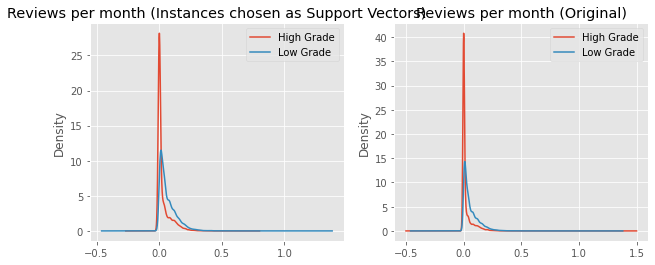

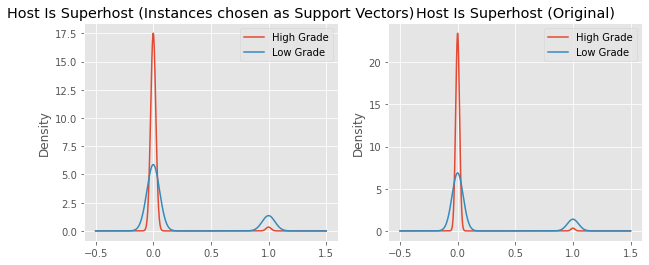

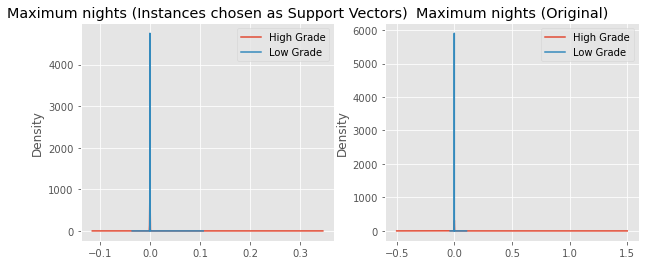

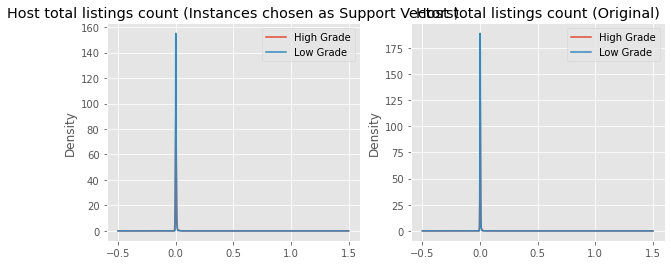

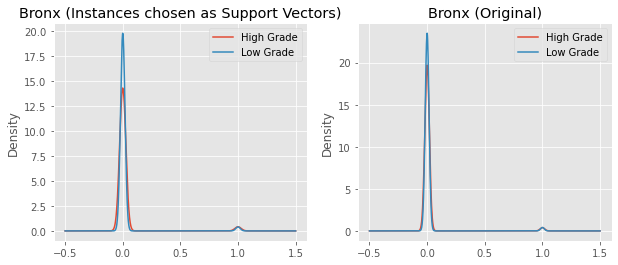

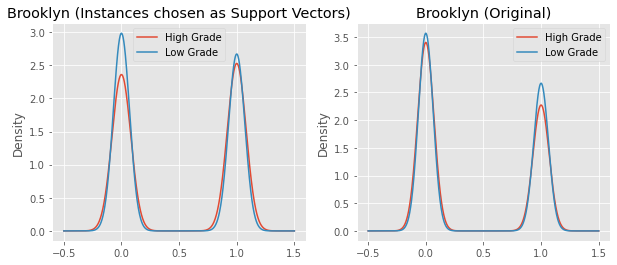

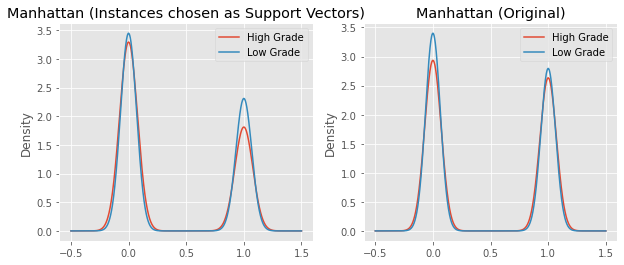

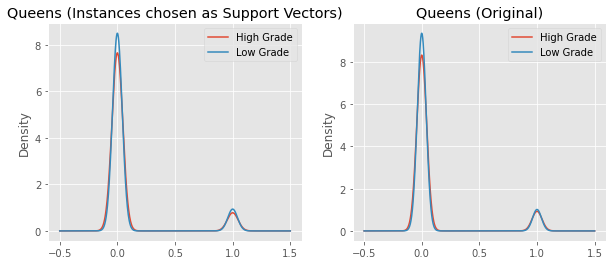

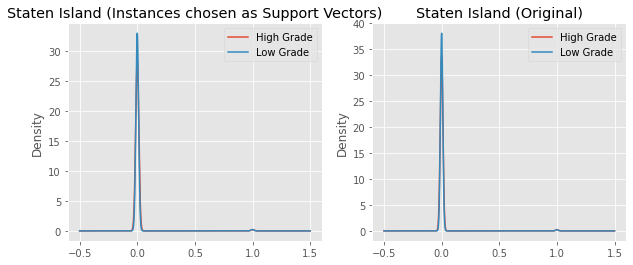

In [35]:
%matplotlib inline
from matplotlib import pyplot as plt

# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['Grade'])
df_grouped = data.groupby(['Grade'])
vars_to_plot = ['Reviews per month','Host Is Superhost', 'Maximum nights','Host total listings count','Bronx','Brooklyn','Manhattan','Queens','Staten Island']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['High Grade','Low Grade'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['High Grade','Low Grade'])
    plt.title(v+' (Original)')

# Feature Interpretation of our support vectors
As discussed above the features we ended up selecting for comparison were 'Reviews per month','Host Is Superhost', 'Maximum nights','Host total listings count','Bronx','Brooklyn','Manhattan','Queens','Staten Island'

We wanted to keep the features that were tested uniform throughout the lab. We did not use the 'Room type' feature here due to how the data is inputted (entire apt, private room, shared room), it just felt more natural to have these features being compared by their distinction of a high/low grade. From above, any grade below a 90 is deemed 'low', and anything above is deemed 'high'.

Amongst all of these features. I think that the most interesting feature to explore lately has been the "Host Is Superhost" feature. The superhost distinction really is telling to see if a grade will or will not be designated as high. The density tends to be a bit higher in scale on the support vector graph too. This is most likely going to be a linear sepreable variable. 

Reviews per month also has a lot more density on the support vector, and there also tends to be a little less seperation. Why I think this might be is that people who are staying at more reviewed places are probably renting from superhosts, which we have seen in the past is positively correlated with higher grades.

